In [17]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Training Classifier:

In [18]:
import tensorflow as tf
seed = 786
tf.keras.utils.set_random_seed(seed)
# tf.config.experimental.enable_op_determinism()

from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Concatenate, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam, RMSprop



def normalize_array(array):
    normalized_array = np.zeros_like(array)  # Create a new array to store normalized values
    scale_fac = []
    for i in range(array.shape[0]):  # Iterate over samples/events
        max_value = np.max(np.abs(array[i]))  # Calculate the maximum value across both channels
        
        if max_value != 0:  # Avoid division by zero
            normalized_sample = array[i] / max_value
            normalized_array[i] = normalized_sample
        else:
            print("Max vlue 0 encountered at index :", i)
        scale_fac.append(max_value)
    return normalized_array, scale_fac


In [19]:
ant = "ant3"

# Abdul's data
# DataDir = ("/mnt/janus/arehman/work/2023_Split_months_data-Final/JanFeb/2D_CNN/Classifier")

# x_train = np.load(DataDir + f"/TstTrn/{ant}_Traces_train.npy", allow_pickle=True)
# x_test = np.load(DataDir + f"/TstTrn/{ant}_Traces_test.npy", allow_pickle=True)
# y_train = np.load(DataDir + f"/TstTrn/{ant}_Labels_train.npy", allow_pickle=True)
# y_test = np.load(DataDir + f"/TstTrn/{ant}_Labels_test.npy", allow_pickle=True)

# Dana's data
dataset = 'Auger_v5'
DataDir = f"/home/danakull/work/WaveformML/TrainingAndTesting/data-production/taxi-noise/data/Dataset_{dataset}"   ## Enter directories here
x_train = np.load(DataDir + f"/{ant}_traces_train.npy", allow_pickle=True)
x_test = np.load(DataDir + f"/{ant}_traces_test.npy", allow_pickle=True)
y_train = np.load(DataDir + f"/{ant}_labels_train.npy", allow_pickle=True)
y_test = np.load(DataDir + f"/{ant}_labels_test.npy", allow_pickle=True)

x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')


print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

## Convert to 1D for single channel training
# ch0_train, ch1_train = x_train[:,:,0], x_train[:,:,1]
# ch0_test, ch1_test = x_test[:,:,0], x_test[:,:,1]

# x_train = np.concatenate((ch0_train, ch1_train))
# x_test = np.concatenate((ch0_test, ch1_test))

# y_train = np.concatenate((y_train, y_train))
# y_test = np.concatenate((y_test, y_test))


### Normalizing
x_train, scalefac = normalize_array(x_train)
x_test, scalefacT = normalize_array(x_test)

(119761, 1000, 2) (29941, 1000, 2) (119761,) (29941,)


In [20]:
# x_train =  np.array(x_train, dtype='float32')
# print(f"Total size in Mbs = {x_train.nbytes/10**9})

In [21]:
class LearningRateScheduler(Callback):
    def __init__(self, factor, patience):
        super(LearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.wait = 0
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(K.get_value(self.model.optimizer.lr))
                new_lr = old_lr * self.factor
                K.set_value(self.model.optimizer.lr, new_lr)
                self.wait = 0
                print(f"Reducing learning rate to {new_lr}")

                
def Classifier(KS, FIL, Layers, lr=5e-3):
    inputs = Input(shape=(1000, 2))
    x = Conv1D(filters= FIL, kernel_size=KS, padding='same', activation='relu', kernel_initializer='he_normal') (inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters= FIL, kernel_size=KS, padding='same', activation='relu', kernel_initializer='he_normal') (x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters= FIL, kernel_size=KS, padding='same', activation='relu', kernel_initializer='he_normal') (x)
    x = MaxPooling1D(pool_size=2)(x)

    ## Decode
    x = Conv1D(filters= FIL, kernel_size=KS, padding='same', activation='relu', kernel_initializer='he_normal') (x)
    x = UpSampling1D(2)(x)
    x = Conv1D(filters= FIL, kernel_size=KS, padding='same', activation='relu', kernel_initializer='he_normal') (x)
    x = UpSampling1D(2)(x)
    x = Conv1D(filters= FIL, kernel_size=KS, padding='same', activation='relu', kernel_initializer='he_normal') (x)
    x = UpSampling1D(2)(x)
    
    x = Flatten()(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    
    model.compile(optimizer=Adam(learning_rate=lr), loss='bce', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model
                
def CreateModel(KS, FIL, Layers, lr=5e-3):

    # Define the input shape for each polarization
#     input_shape = (1000, 2)  # 2 channels, 1 for each polarization
    input_shape = (1000, 1)  # 2 channels, 1 for each polarization
    

    # Define the input layer
    input_layer = Input(shape=input_shape)
    x = input_layer

    # Convolutional layers
    for i in range(Layers):
        x = Conv1D(filters=FIL, kernel_size=KS, activation='relu', padding='same')(x)
        x = MaxPooling1D(pool_size=2)(x)

    # Flatten the pooled output
    x = Flatten()(x)
    
#     x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output)

    # Compile the model
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['accuracy', f1_score, precision, recall_m])
    model.compile(optimizer=Adam(learning_rate=lr), loss='bce', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
#     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=[tf.keras.metrics.Recall(), recall_m])
    
    return model

In [22]:
# ModelsDir = "./1D_models"
ModelsDir = DataDir + "/../../../../training/classifier"
### Fitting (Training the data)
lr_scheduler = LearningRateScheduler(factor=0.5, patience=5)
es = EarlyStopping(monitor='val_loss', mode='min',restore_best_weights=True, verbose=1, patience=5)
mc = ModelCheckpoint(ModelsDir+f'/data/models/Classifier_BCE_{dataset}/Classifier_{ant}.h5',
                                    monitor = 'val_loss', mode = 'min', verbose=1, save_best_only=True)

autoencoder = Classifier(KS=33, FIL=12, Layers=3, lr=1e-4)

history = autoencoder.fit(x_train, y_train,
                        epochs=200,
                        batch_size=300,
                        shuffle=True,
                        validation_data=(x_test, y_test),
                        callbacks=[lr_scheduler, es, mc])

Epoch 1/200
400/400 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.6087 - precision_1: 0.7371 - recall_1: 0.3390
Epoch 00001: val_loss improved from inf to 0.60823, saving model to /home/danakull/work/WaveformML/TrainingAndTesting/data-production/taxi-noise/data/Dataset_Auger_v5/../../../../training/classifier/data/models/Classifier_BCE_Auger_v5/Classifier_ant3.h5
400/400 [==============================] - 13s 24ms/step - loss: 0.6245 - accuracy: 0.6087 - precision_1: 0.7371 - recall_1: 0.3390 - val_loss: 0.6082 - val_accuracy: 0.6232 - val_precision_1: 0.7642 - val_recall_1: 0.3521
Epoch 2/200
400/400 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.6216 - precision_1: 0.8300 - recall_1: 0.3068
Epoch 00002: val_loss improved from 0.60823 to 0.60531, saving model to /home/danakull/work/WaveformML/TrainingAndTesting/data-production/taxi-noise/data/Dataset_Auger_v5/../../../../training/classifier/data/models/Classifier_BCE_Auger_v5/Classifi

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1'])

In [24]:
train_pre = history.history[list(history.history.keys())[2]]
test_pre = history.history[list(history.history.keys())[6]]

train_recall = history.history[list(history.history.keys())[3]]
test_recall = history.history[list(history.history.keys())[7]]

train_loss = history.history[list(history.history.keys())[0]]
test_loss = history.history[list(history.history.keys())[4]]

train_accu = history.history[list(history.history.keys())[1]]
test_accu = history.history[list(history.history.keys())[5]]

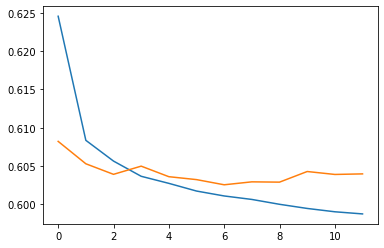

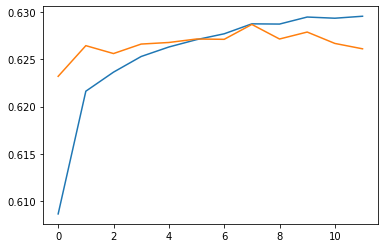

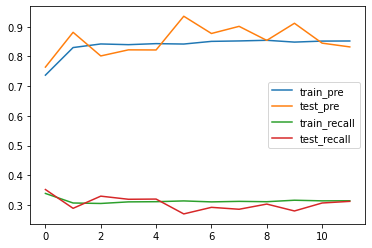

In [25]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.figure()
plt.plot(train_accu, label="train_accu")
plt.plot(test_accu, label="test_accu")
plt.figure()
plt.plot(train_pre, label="train_pre")
plt.plot(test_pre, label="test_pre")

plt.plot(train_recall, label="train_recall")
plt.plot(test_recall, label="test_recall")

plt.legend()

plt.savefig(ModelsDir+f'/plots/Classifier_BCE_{dataset}_Plots/Classifier_{ant}.png')

# Training Denoiser

In [26]:
import tensorflow as tf
seed = 786
tf.keras.utils.set_random_seed(seed)
# tf.config.experimental.enable_op_determinism()

from tensorflow.keras import backend as K
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Concatenate, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam, RMSprop



def GetChunkSNR(trace, No_Chunks):
    Amps = np.array(trace)

    Trace_Peak = np.max(np.abs(Amps))  ## to save computation time, otherwise hilberenvelop can also be used
    Chunks = np.array_split(Amps, No_Chunks)
    ChunkRMS_squared = [(sum(chunk ** 2)) / len(chunk) for chunk in Chunks]
    RMS_squared_Median = np.median(ChunkRMS_squared)
    SNR = Trace_Peak ** 2 / RMS_squared_Median

    return SNR


def GettrueSNR(trace, label, No_Chunks=10):
    Amps = np.array(trace)

    Trace_Peak = np.max(np.abs(label))  ## to save computation time, otherwise hilberenvelop can also be used
#     Trace_Peak = np.max(np.abs(Amps))  ## to save computation time, otherwise hilberenvelop can also be used
    Chunks = np.array_split(Amps, No_Chunks)
    ChunkRMS_squared = [(sum(chunk ** 2)) / len(chunk) for chunk in Chunks]
    RMS_squared_Median = np.median(ChunkRMS_squared)
    SNR = Trace_Peak ** 2 / RMS_squared_Median

    return SNR

def normalize_deno_array(array, y_array):
    normalized_array = np.zeros_like(array)  # Create a new array to store normalized values
    normalized_y_array = np.zeros_like(array)  # Create a new array to store normalized values
    
    scale_fac = []
    for i in range(array.shape[0]):  # Iterate over samples/events
        max_value = np.max(np.abs(array[i]))  # Calculate the maximum value across both channels
        
        if max_value != 0:  # Avoid division by zero
            normalized_sample = array[i] / max_value
            normalized_array[i] = normalized_sample
            
            ## Normalizing labels
            normalized_y_sample = y_array[i] / max_value
            normalized_y_array[i] = normalized_y_sample
            
        else:
            print("Max vlue 0 encountered at index :", i)
        scale_fac.append(max_value)
    return normalized_array, normalized_y_array, scale_fac


In [27]:
ant = "ant3"

DataDir = f"/home/danakull/work/WaveformML/TrainingAndTesting/data-production/taxi-noise/data/Dataset_{dataset}"   ## Enter directories here
# DataDir = ("/mnt/janus/arehman/work/2023_Split_months_data/MayJune/2D_CNN/Denoiser/TstTrn")

x_train = np.load(DataDir + f"/{ant}_noisy_train.npy", allow_pickle=True)
x_test = np.load(DataDir + f"/{ant}_noisy_test.npy", allow_pickle=True)

y_train = np.load(DataDir + f"/{ant}_pure_train.npy", allow_pickle=True)
y_test = np.load(DataDir + f"/{ant}_pure_test.npy", allow_pickle=True)

x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')


# ########
# ## For Single channel 
# train_pol0 = [x_train[:, :, 0][i] for i in range(len(x_train))]
# train_pol1 = [x_train[:, :, 1][i] for i in range(len(x_train))]

# test_pol0 = [x_test[:, :, 0][i] for i in range(len(x_test))]
# test_pol1 = [x_test[:, :, 1][i] for i in range(len(x_test))]


# train_lab_pol0 = [y_train[:, :, 0][i] for i in range(len(y_train))]
# train_lab_pol1 = [y_train[:, :, 1][i] for i in range(len(y_train))]

# test_lab_pol0 = [y_test[:, :, 0][i] for i in range(len(y_test))]
# test_lab_pol1 = [y_test[:, :, 1][i] for i in range(len(y_test))]

# x_train = np.concatenate((train_pol0, train_pol1))
# x_test = np.concatenate((test_pol0, test_pol1))

# y_train = np.concatenate((train_lab_pol0, train_lab_pol1))
# y_test = np.concatenate((test_lab_pol0, test_lab_pol1))


### Normalizing
x_train, y_train, scalefac = normalize_deno_array(x_train, y_train)
x_test, y_test, scalefacT = normalize_deno_array(x_test, y_test)

In [28]:
class LearningRateScheduler(Callback):
    def __init__(self, factor, patience):
        super(LearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.wait = 0
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(K.get_value(self.model.optimizer.lr))
                new_lr = old_lr * self.factor
                K.set_value(self.model.optimizer.lr, new_lr)
                self.wait = 0
                print(f"Reducing learning rate to {new_lr}")

def CorrCoeff(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = mx
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    return r
# Custom correlation metric
def CC2(y_true, y_pred):
    def pearson_correlation(x, y):
        mean_x = K.mean(x)
        mean_y = K.mean(y)
        cov_xy = K.sum((x - mean_x) * (y - mean_y))
        std_x = K.sqrt(K.sum(K.square(x - mean_x)))
        std_y = K.sqrt(K.sum(K.square(y - mean_y)))
        correlation = cov_xy / (std_x * std_y)
        return correlation

    correlation = tf.py_function(pearson_correlation, [y_true, y_pred], tf.float32)
    return correlation


def Denoiser(fil, ks, lr=1e-3):
#     input_shape = (1000, 2)
    input_shape = (1000, 1)

    # Encoder architecture
    input_layer = Input(shape=input_shape)

#     fil, ks = 4, 20
    x = Conv1D(fil, ks, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(fil, ks, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(fil, ks, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
#     x = Conv1D(fil, ks, activation='relu', padding='same')(x)
#     x = MaxPooling1D(2)(x)

# #     x = Conv1D(fil, ks, activation='relu', padding='same')(x)
#     # Decoder architecture
#     x = Conv1D(fil, ks, activation='relu', padding='same')(x)
#     x = UpSampling1D(2)(x)
    x = Conv1D(fil, ks, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(fil, ks, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(fil, ks, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
#     decoded = Conv1D(2, ks, activation='linear', padding='same')(x)
    decoded = Conv1D(1, ks, activation='linear', padding='same')(x)
    

    # Create the autoencoder model
    autoencoder = Model(input_layer, decoded)

    # Compile the model
    autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=[CC2])
    
    return autoencoder

In [29]:
# ########
# ## For Single channel 
train_pol0 = [x_train[:, :, 0][i] for i in range(len(x_train))]
train_pol1 = [x_train[:, :, 1][i] for i in range(len(x_train))]

test_pol0 = [x_test[:, :, 0][i] for i in range(len(x_test))]
test_pol1 = [x_test[:, :, 1][i] for i in range(len(x_test))]


train_lab_pol0 = [y_train[:, :, 0][i] for i in range(len(y_train))]
train_lab_pol1 = [y_train[:, :, 1][i] for i in range(len(y_train))]

test_lab_pol0 = [y_test[:, :, 0][i] for i in range(len(y_test))]
test_lab_pol1 = [y_test[:, :, 1][i] for i in range(len(y_test))]

x_train = np.concatenate((train_pol0, train_pol1))
x_test = np.concatenate((test_pol0, test_pol1))

y_train = np.concatenate((train_lab_pol0, train_lab_pol1))
y_test = np.concatenate((test_lab_pol0, test_lab_pol1))

In [30]:
ModelsDir = DataDir + f"/../../../../training/denoiser"
### Fitting (Training the data)
lr_scheduler = LearningRateScheduler(factor=0.5, patience=5)
es = EarlyStopping(monitor='val_loss', mode='min',restore_best_weights=True, verbose=1, patience=5)
mc = ModelCheckpoint(ModelsDir+f'/data/models/Denoiser_MSE_{dataset}/Denoiser_{ant}.h5',
                                    monitor = 'val_loss', mode = 'min', verbose=1, save_best_only=True)

autoencoder = Denoiser(fil=12, ks=33, lr=1e-4)

# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

history = autoencoder.fit(x_train, y_train, 
                        epochs=500, 
                        batch_size=200, shuffle=True,
                        validation_data=(x_test, y_test), 
                        callbacks=[lr_scheduler, es, mc])

Epoch 1/500
599/599 [==============================] - ETA: 0s - loss: 0.0012 - CC2: 0.0100
Epoch 00001: val_loss improved from inf to 0.00121, saving model to /home/danakull/work/WaveformML/TrainingAndTesting/data-production/taxi-noise/data/Dataset_Auger_v5/../../../../training/denoiser/data/models/Denoiser_MSE_Auger_v5/Denoiser_ant3.h5
599/599 [==============================] - 16s 21ms/step - loss: 0.0012 - CC2: 0.0100 - val_loss: 0.0012 - val_CC2: 0.0240
Epoch 2/500
598/599 [============================>.] - ETA: 0s - loss: 8.5922e-04 - CC2: 0.4391
Epoch 00002: val_loss improved from 0.00121 to 0.00047, saving model to /home/danakull/work/WaveformML/TrainingAndTesting/data-production/taxi-noise/data/Dataset_Auger_v5/../../../../training/denoiser/data/models/Denoiser_MSE_Auger_v5/Denoiser_ant3.h5
599/599 [==============================] - 12s 20ms/step - loss: 8.5869e-04 - CC2: 0.4397 - val_loss: 4.7310e-04 - val_CC2: 0.7044
Epoch 3/500
599/599 [==============================] - ETA

In [31]:
history.history.keys()
print(history.history.keys())

# train_pre = history.history[list(history.history.keys())[2]]
# test_pre = history.history[list(history.history.keys())[6]]

# train_recall = history.history[list(history.history.keys())[3]]
# test_recall = history.history[list(history.history.keys())[7]]

train_loss = history.history[list(history.history.keys())[0]]
test_loss = history.history[list(history.history.keys())[2]]

train_accu = history.history[list(history.history.keys())[1]]
test_accu = history.history[list(history.history.keys())[3]]

dict_keys(['loss', 'CC2', 'val_loss', 'val_CC2'])


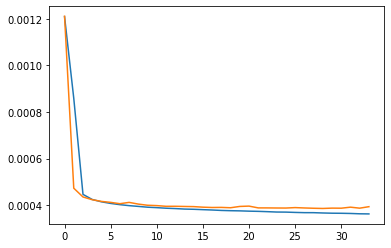

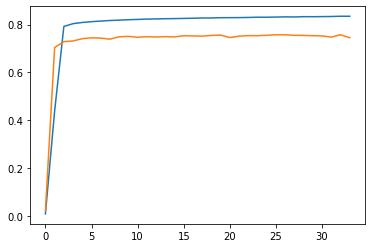

<Figure size 432x288 with 0 Axes>

In [32]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.figure()
plt.plot(train_accu, label="train_accu")
plt.plot(test_accu, label="test_accu")
plt.figure()

plt.savefig(ModelsDir+f'/plots/Denoiser_MSE_{dataset}_Plots/Denoiser_{ant}.png')